In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = None

Let's load the data and take a first look at it.

In [2]:
df = pd.read_csv('data/bank-full.csv', sep=";")

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Here is the official description of the attributes of our dataset.


#### Bank client data:

- **1 - age (numeric)**
- **2 - job (categorical)** : type of job ('admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
- **3 - marital (categorical)** : marital status ('divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)
- **4 - education (categorical)** : 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
- **5 - default (categorical)** : has credit in default? ('no', 'yes', 'unknown')
- **6 - housing (categorical)** : has housing loan? ('no', 'yes', 'unknown')
- **7 - loan (categorical)** : has personal loan? ('no', 'yes', 'unknown')

#### Related with the last contact of the current campaign:

- **8 - contact (categorical)** : contact communication type ('cellular', 'telephone')
- **9 - month (categorical)**: last contact month of year ('jan', 'feb', 'mar', ..., 'nov', 'dec')
- **10 - day_of_week (categorical)** : last contact day of the week ('mon', 'tue', 'wed', 'thu', 'fri')
- **11 - duration (numeric)** : last contact duration, in seconds. Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### Other attributes:
- **12 - campaign (numeric, includes last contact)** : number of contacts performed during this campaign and for this client
- **13 - pdays (numeric; 999 means client was not previously contacted)** : number of days that passed by after the client was last contacted from a previous campaign 
- **14 - previous (numeric)** : number of contacts performed before this campaign and for this client
- **15 - poutcome (categorical)** : outcome of the previous marketing campaign ('failure', 'nonexistent', 'success')

#### Social and economic context attributes

- **16 - emp.var.rate (numeric)** : employment variation rate - quarterly indicator
- **17 - cons.price.idx (numeric)** : consumer price index - monthly indicator
- **18 - cons.conf.idx (numeric)** : consumer confidence index - monthly indicator
- **19 - euribor3m (numeric)** : euribor 3 month rate - daily indicator
- **20 - nr.employed (numeric)** : number of employees - quarterly indicator

#### Output variable (desired target):
- **21 - y (binary)** : has the client subscribed a term deposit? ('yes', 'no')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

We have **41188 entries** and **21 columns**. The column **'y'** is the one we will try to predict.

The numerical columns were correctly identified by pandas and categorical features were loaded with the object dtype. We convert these columns to the categorical dtype.

In [5]:
cat_cols = [column_name for column_name in df.columns if str(
    df[column_name].dtype) == 'object']
num_cols = [
    column_name for column_name in df.columns if column_name not in cat_cols]
df[cat_cols] = df[cat_cols].astype('category')

Some values are missing and currently market as unknown in the dataset. We will keep them for our exploratory analysis and will impute them after using the KNN imputer from scikit-learn.

## 1. Exploratory Data Analysis

### 1.1 Univariate analysis

We define a helper function to make bar plots for categorical variables.

In [6]:
def plot_cat_bars(cols):
    if isinstance(cols, str):
        cols = [cols]
    n_cols = 2
    n_rows = int(np.ceil(len(cols)/n_cols))
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                             figsize=(15, 4 * n_rows), squeeze=False)
    for i, column in enumerate(cols):  # last column is the target variable
        df[column].value_counts().plot(
            kind='bar', ax=axes[i//n_cols, i % n_cols], title=column, rot=45)
    if len(cols) % 2 == 1:
        axes[-1, -1].set_visible(False)

#### 1.1.1 Target variable

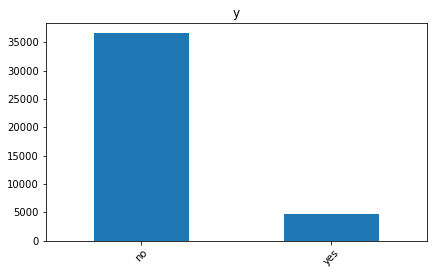

In [7]:
plot_cat_bars('y')

In [8]:
np.sum(df['y'] == 'yes') / df.shape[0]

0.11265417111780131

Clients subscribe to a term deposit in only **11.2%** of the cases. This is a significant **class imbalance** in our target variable which we will need to take into consideration in our models.

#### 1.1.2 Categorical features

Let's take a look at our categorical features distributions.

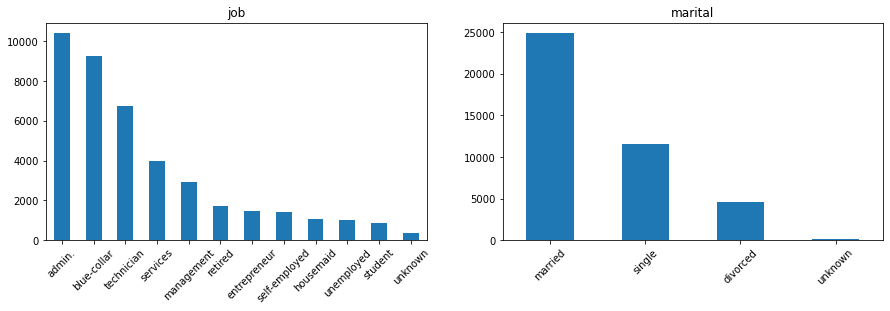

In [9]:
plot_cat_bars(["job", "marital"])

- There are very few unknown values for the job and marital features so imputing new values using KNN should work just fine.

- Distributions across categories are clearly not uniform.

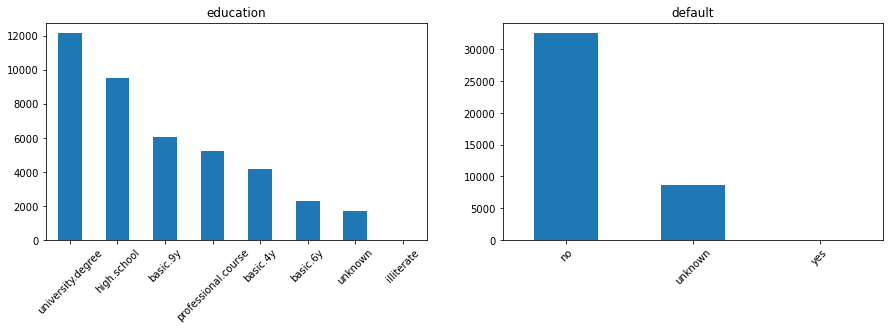

In [10]:
plot_cat_bars(['education', 'default'])

- Few unknown values for the education variable
- Much more unknowns for the default column. Also, there seems to be very few yes values.

In [11]:
df["default"].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

There are so few persons that have credit in default that the default column looks really useless for our model. Indeed people with credit in default won't be able to get a new loan anyways.

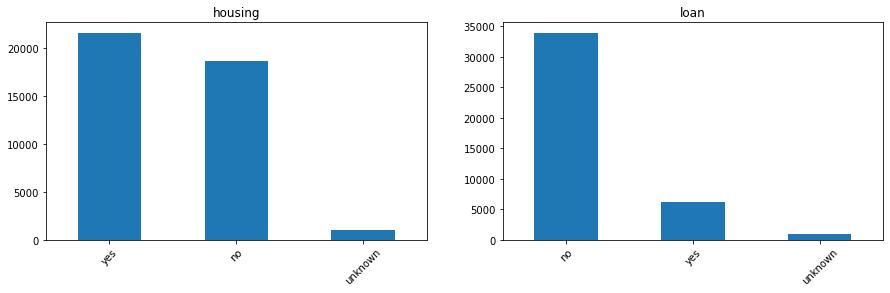

In [12]:
plot_cat_bars(['housing', 'loan'])

- Few unknown variables for housing and loan.
- Distribution is relatively balanced for the housing variable.
- Most people don't have a loan.

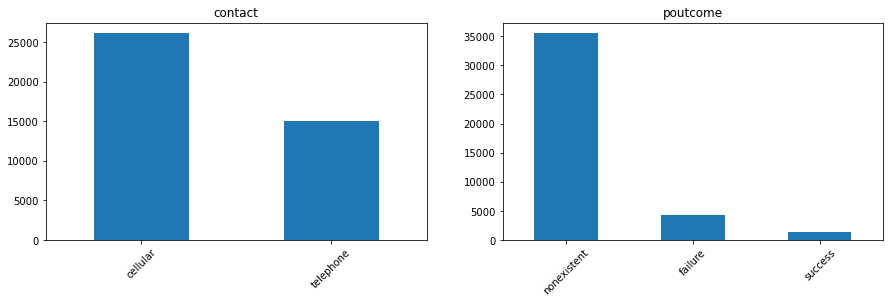

In [13]:
plot_cat_bars(['contact', 'poutcome'])

- Most people are contacted through cellular
- A majority of the clients haven't been previously contacted in a marketing campaign.

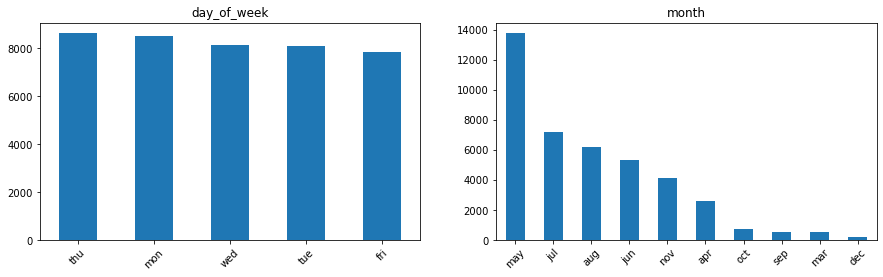

In [14]:
plot_cat_bars(['day_of_week', 'month'])

- Contacts are distributed evenly across the days of the week
- There were very few contacts during March, September, October and December : this is important as we will see later that the target variable distribution is very different in these particular months. Most of the marketing campaign was done in May.

#### 1.1.3 Numerical features

We will now take a look at the numerical columns.

We define a helper function to analyze our numerical features.

In [15]:
def plot_num_cols(cols):
    if isinstance(cols, str):
        cols = [cols]
    n_cols = 2
    n_rows = len(cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                             figsize=(15, 4 * n_rows), squeeze=False)
    for i, column in enumerate(cols):  # last column is the target variable
        df[column].hist(ax=axes[i, 0], bins=25)
        axes[i, 0].set_xlabel(column)
        sns.boxplot(x=df[column], ax=axes[i, 1])

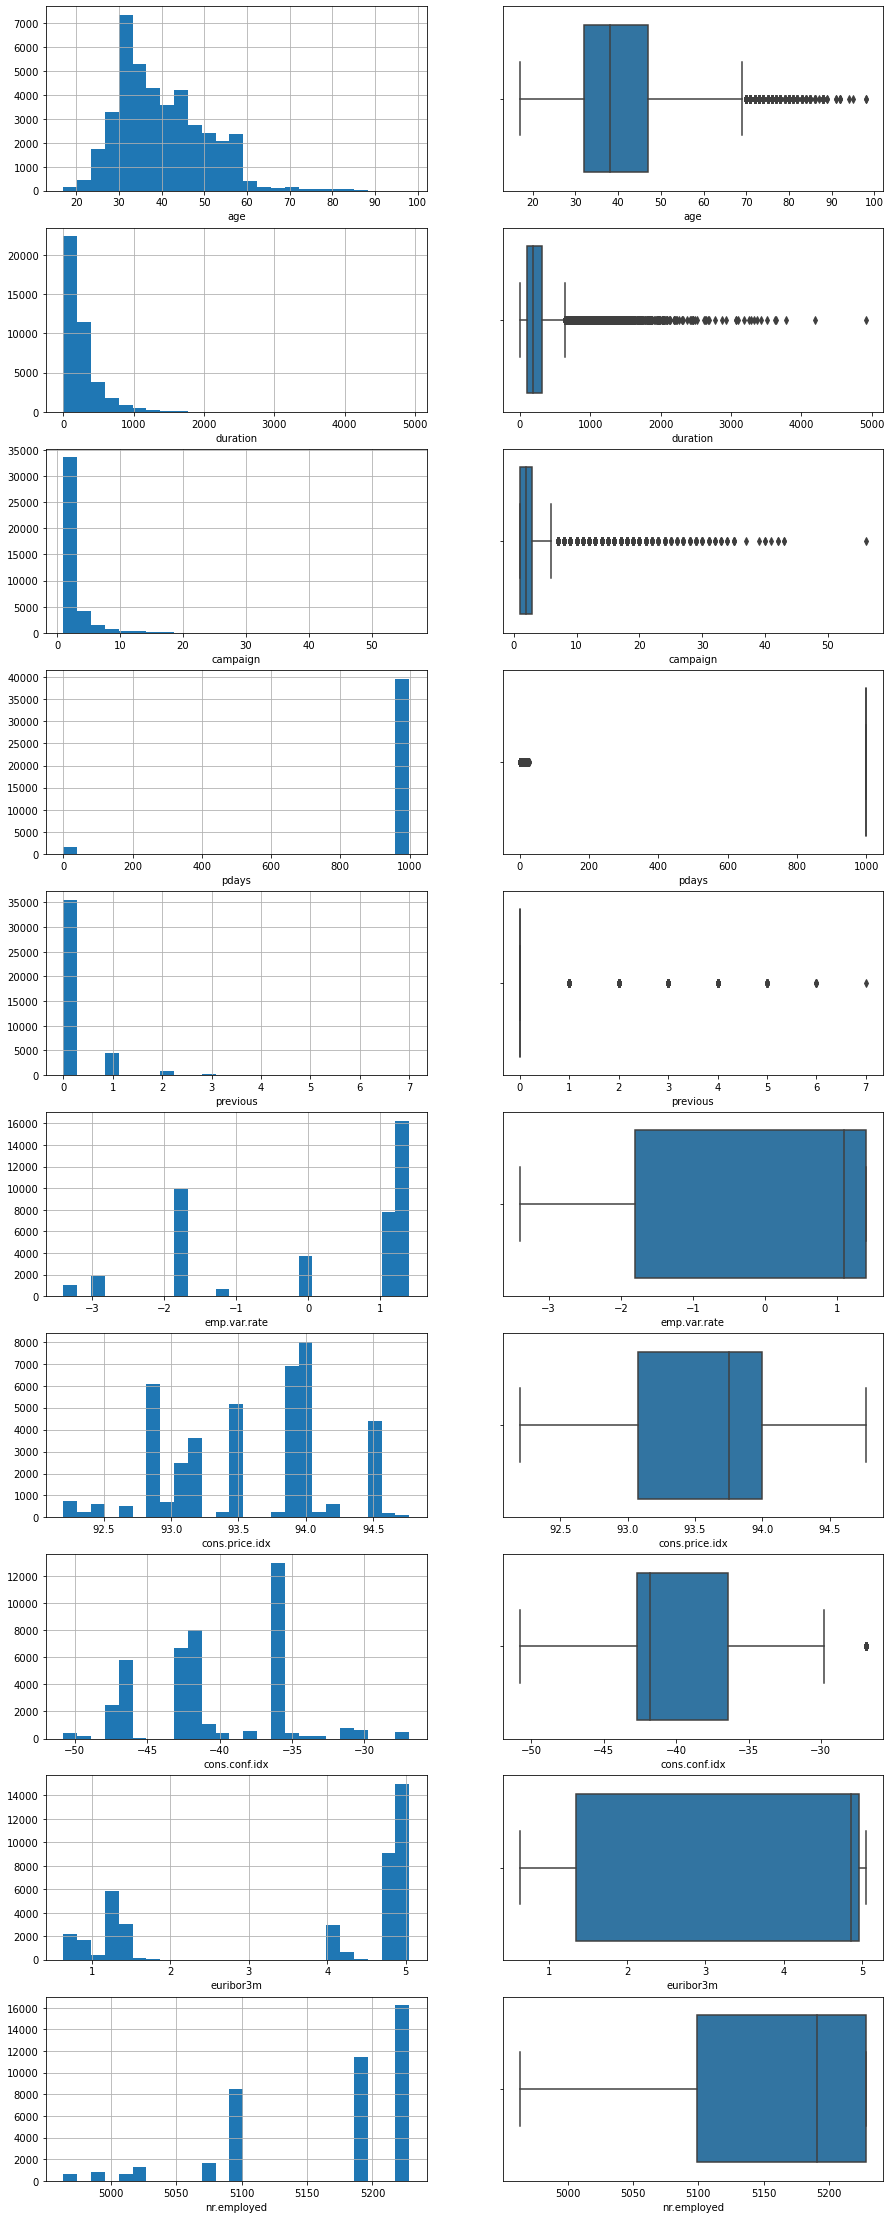

In [16]:
plot_num_cols(num_cols)

- the only feature that looks approximately gaussian is the age variable.


- other features are either skewed right (duration, campaign, previous), left (cons.price, nr.employed) or concentrated around few spikes.


- age, duration and campaign have some outliers. However, those outliers are most likely not errors since it is reasonable to think that some people might have more than 90 years old, that some calls might have lasted more than an hour and that some people might have been contacted 50 times. As a result, in our future models, we'll have to either use algorithms robust to outliers or evaluate the impact of the outliers on the result.


- concerning pdays, we see that more than 75% of people were never contacted before for a loan so maybe it would be better to create a binary variable which states whether the person was contacted before instead of this representation. A similar situation shows for previous.


- even though some features are floats, there seem to be only a handle of discrete values per column : this is confirmed by the following table.

In [17]:
number_of_cats = [df[col].nunique() for col in num_cols]
pd.DataFrame(
    {'Column': num_cols, 'Number of different values': number_of_cats})

,Column,Number of different values
0,age,78
1,duration,1544
2,campaign,42
3,pdays,27
4,previous,8
5,emp.var.rate,10
6,cons.price.idx,26
7,cons.conf.idx,26
8,euribor3m,316
9,nr.employed,11


#### 1.1.4 Missing values

In [18]:
(df == 'unknown').sum(axis=0)

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

We will need to handle the missing values in job, marital, education, default, housing and loan columns.

As seen in the previous plots, the 'default', 'loan' and 'marital' histograms have a highly represented value so we could replace the missing values by the most frequent value for these columns.

In the three other categorical columns with missing values (job, education, housing), we don't have a highly represented value.

The imputation strategy that we used for the missing values is using KNN imputation. It is implemented after the EDA analysis.

### 1.2 Bivariate analysis

#### 1.2.1 Features vs features

#### Correlations (numerical features only)

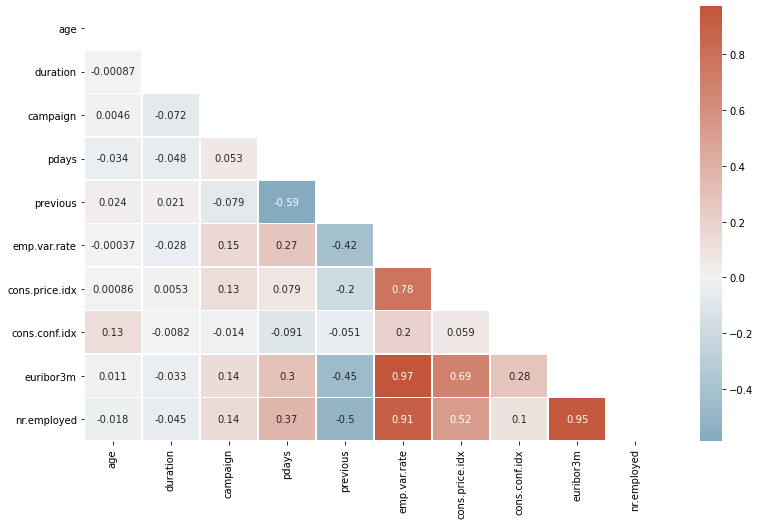

In [19]:
corr = df.drop('y', axis = 1).corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)
f, ax = plt.subplots(figsize=(13,8))
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, xticklabels=corr.columns, mask = mask, yticklabels=corr.columns,
            center=0, linewidths=.5, cmap=sns.diverging_palette(230, 20, as_cmap=True), annot = True)

Significant correlations between our features (abs > 0.5) are :

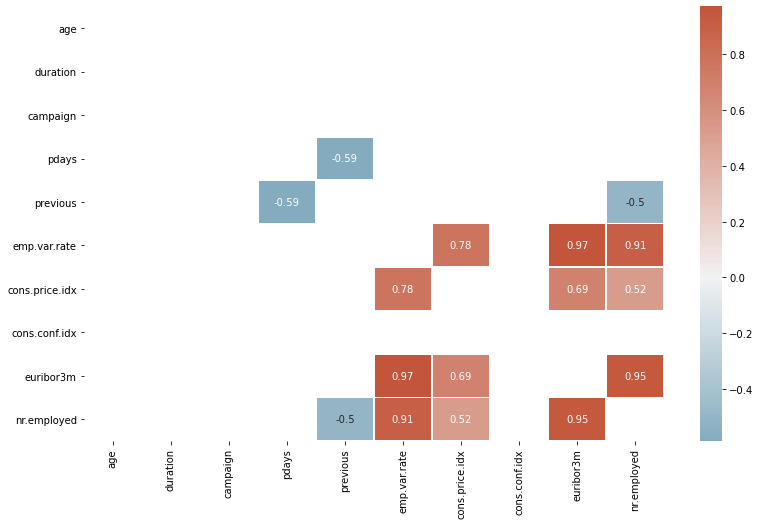

In [20]:
f, ax = plt.subplots(figsize=(13,8))
np.fill_diagonal(corr.values, 0)
mask = (abs(corr) < 0.5)
ax = sns.heatmap(corr, xticklabels=corr.columns, mask = mask, yticklabels=corr.columns,
            center=0, linewidths=.5, cmap=sns.diverging_palette(230, 20, as_cmap=True), annot = True)

From this representation, it is very clear that emp.var.rate, euribor3m and nr.employed are highly correlated. We will likely need to drop one or two of these variables in our models.

#### 1.2.2 Features vs target

The correlations are very different depending on the categories, we will do further analysis before our first conclusions. We will factorize the variable we want to predict as it will be useful to continue our analysis.

In [21]:
target_map = {'yes': 1, 'no': 0}
df['y'] = pd.to_numeric(df['y'].map(target_map))

In [22]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


##### 1.2.2.1 Categorical features

Helper function to plot the loan acceptance ratios in each category of a column.

In [23]:
def plot_acceptance_ratio_bars(cols, num_quantiles = 10):
    
    if isinstance(cols, str):
        cols = [cols]
    n_cols = 2
    n_rows = int(np.ceil(len(cols)/n_cols))
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows), squeeze=False) 
    
    for i, col in enumerate(cols):
        plt.sca(axes[i//n_cols, i % n_cols])
        if col in cat_cols:
            sns.barplot(x=col, y="y", data=df)
        else:
            suffix = " (" , num_quantiles , " quantiles)"
            s = pd.qcut(df[col], num_quantiles,
                                       duplicates='drop', precision=0)
            sns.barplot(x=s, y=df["y"])
        plt.xticks(rotation=45)
        
    if len(cols) % 2 == 1:
        axes[-1, -1].set_visible(False)
        
    fig.subplots_adjust(hspace=0.75)

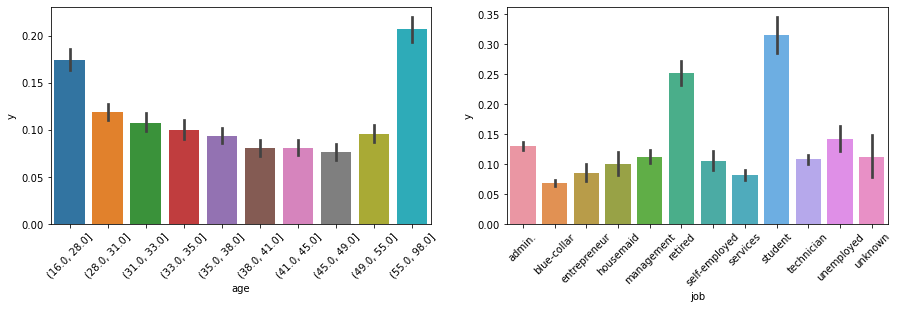

In [24]:
plot_acceptance_ratio_bars(['age', 'job'])

- Student and retired people seem to be significantly more likely to accept a loan.

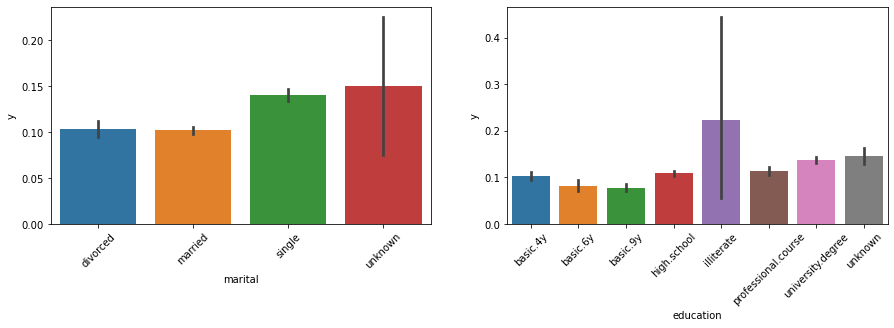

In [25]:
plot_acceptance_ratio_bars(['marital', 'education'])

- Loan acceptance varies quite significantly depending on education
- Single persons are more likely to accept which is most likely related to the age factor. The marital column might bring very similar information to the age. Indeed we saw above that the likelihood that a student accepts a loan is much higher than for other categories and most students are single as you can see below.

In [26]:
df.loc[df["job"] == "student", "marital"].value_counts()

single      824
married      41
divorced      9
unknown       1
Name: marital, dtype: int64

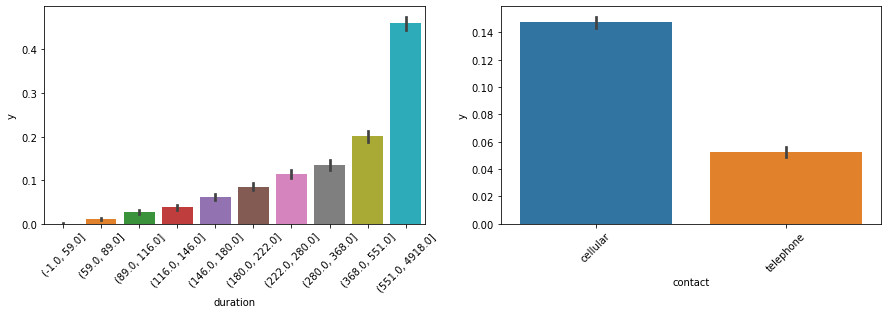

In [27]:
plot_acceptance_ratio_bars(['duration', 'contact'])

- Concerning contact, customer contacted by telephone instead of cellular seem to be unappealing.
- Unsurprisingly the longer a call goes, the higher the chance the customer is interested by the loan and likely to accept it.

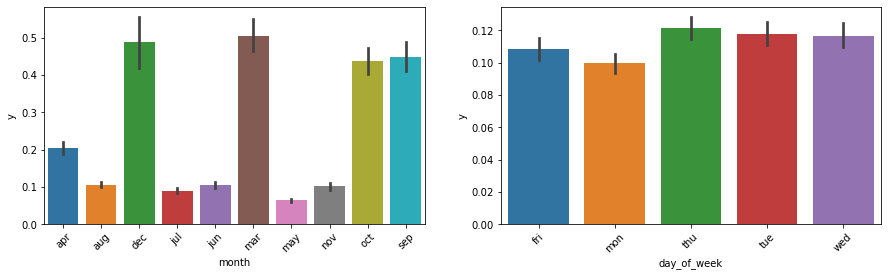

In [28]:
plot_acceptance_ratio_bars(['month', 'day_of_week'])

- We notice that some months like March, September, October and December have a very high percentage of loan accepted. However, these months are not very represented in the dataset. We can assume that there was a particular target for these months with very interested customers. We will create a column special_month to differentiate customers.

- The influence of the days of the week on the loan acceptance seems pretty low.

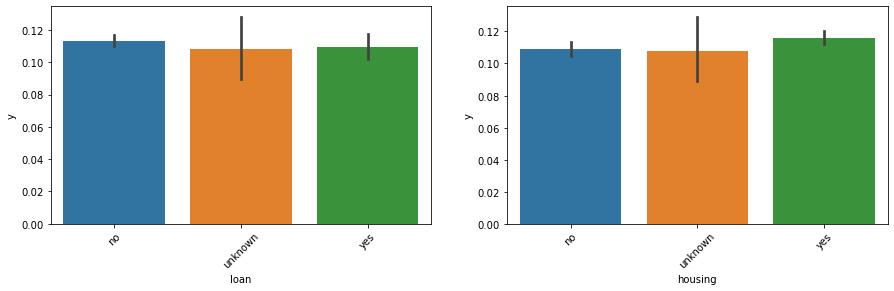

In [29]:
plot_acceptance_ratio_bars(['loan', 'housing'])

- Whether the person already has a loan or not doesn't seem to impact much the acceptance ratio. The differences are slight.

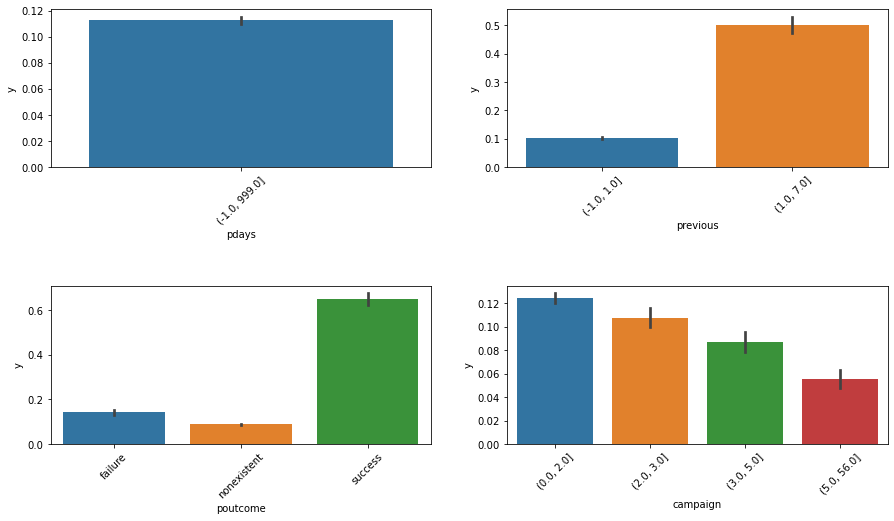

In [30]:
plot_acceptance_ratio_bars(['pdays', 'previous', 'poutcome', 'campaign'])

- People that were contacted in previous campaigns seem more likely to accept a loan.
- However, the more a person gets contacted within a campaign, the less likely it seems that she will accept a loan. Contacting several times the same person seems like a waste of time.
- People that already accepted a loan in a previous campaign have a high chance of reaccepting.

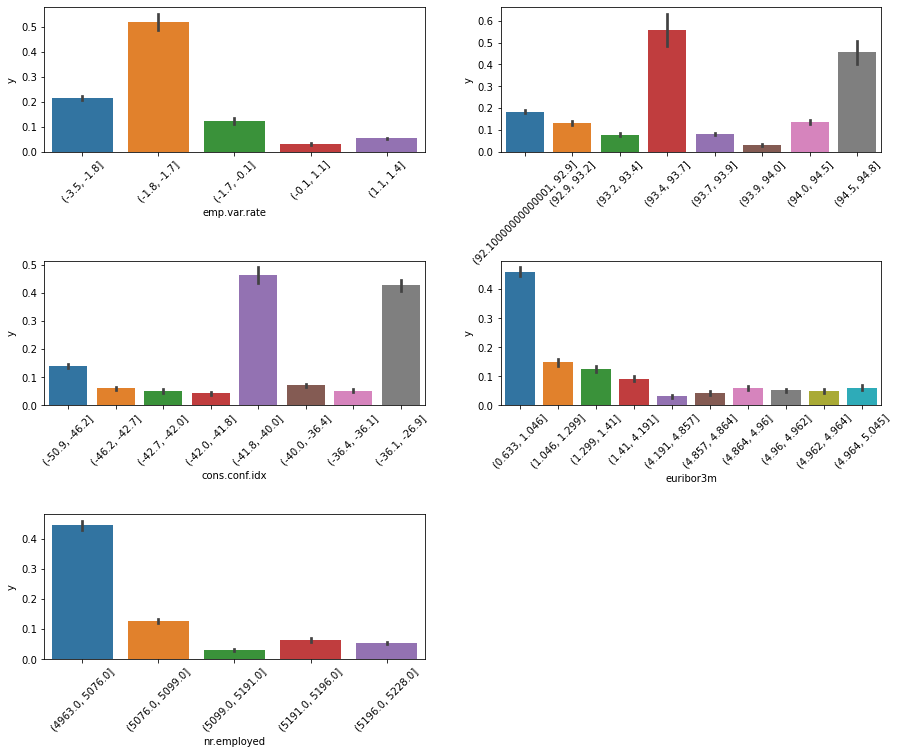

In [31]:
plot_acceptance_ratio_bars(['emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'])

Macro economic indicators are hard to interpret since the high acceptances spikes that we see might be related to the  acceptance outliers of March, September, October and December that we saw previously.

Maybe a density view would be more appropriate for these variables.

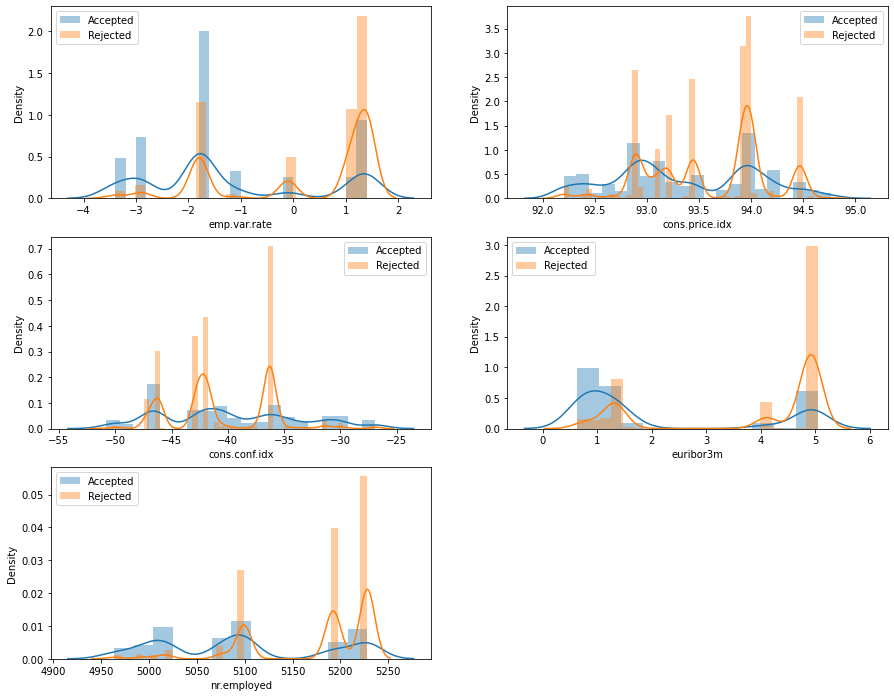

In [32]:
import warnings
warnings.filterwarnings("ignore")

accepted_df = df[df['y'] == 1]
rejected_df = df[df['y'] == 0]

n_rows = 3
n_cols = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows), squeeze=False) 
    
for i, col in enumerate(['emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']):
    plt.sca(axes[i//n_cols, i % n_cols])
    sns.distplot(accepted_df[col], label='Accepted')
    sns.distplot(rejected_df[col], label='Rejected')
    plt.legend()
    

axes[-1, -1].set_visible(False)
    
warnings.filterwarnings("default")

- Lower (negative) employment variation rate, lower consummation price index, lower euribor rate and lower number of employees seem to have a positive impact on loan contraction. Economical situation looks very correlated with loan contraction.
- Consumer confidence is hard to interpret.

## 2. Prediction models

### 2.1 Reload data and preprocess before models 

In [33]:
from sklearn.impute import KNNImputer

# load data
df = pd.read_csv('data/bank-full.csv', sep=";")

# convert categorical columns to categorical type
cat_cols = [column_name for column_name in df.columns if str(
    df[column_name].dtype) == 'object']
num_cols = [
    column_name for column_name in df.columns if column_name not in cat_cols]
df[cat_cols] = df[cat_cols].astype('category')

# replace missing values by np.nan
df = df.replace('unknown', np.nan)

# one hot encode to be able to use KNNImputation
df = pd.get_dummies(df, dummy_na=True)
for col in cat_cols:
    df.loc[df[col + "_nan"] == 1, df.columns.str.startswith(col)] = np.nan
    del df[col + "_nan"]

# impute values
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df.values),columns = df.columns)

# revert dummification
for col in cat_cols:
    df[col] = df.loc[:, df.columns.str.startswith(col)].idxmax(axis=1).str.replace(col + "_", '')
    df = df.loc[:,~df.columns.str.startswith(col + "_")] 

# reset categorical column types
df[cat_cols] = df[cat_cols].astype('category')

# convert target variable to binary 0-1

target_map = {'yes': 1, 'no': 0}
df['y'] = pd.to_numeric(df['y'].map(target_map))

df.head()

C:\Users\matth\Miniconda3\envs\chall_multi\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,56.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,0
1,57.0,149.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,services,married,high.school,no,no,no,telephone,may,mon,nonexistent,0
2,37.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,0
3,40.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,0
4,56.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,0
